### FULL Bayes

This code implements the Full Bayes version of CIFAR-10 classifier. In this method, we no longer assume the features to be independent. Instead of a three 1-Dimensional Gaussians, Now, we assume a single 3-Dimensional Gaussian. We'll use multivariate normal distribution and now, using the formula given below we calculate the new predictions.

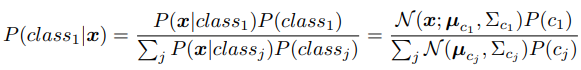

in which x = (mR, mG, mB)<sup>T</sup>
is a three-dimensional vector

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import transform
from scipy.stats import norm
from scipy.stats import multivariate_normal

def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

datadict_tst = unpickle(r'/cifar-10/test_batch') #Loads all unpickled raw Test data in datadict_tst variable

def Load_Data(Data_sets):
    LBL=[]
    for i in range(1, Data_sets+1):

        path='/cifar-10/data_batch_{}'.format(i)
        Load = unpickle(r'{}'.format(path))
        DAT=Load["data"]           
        LBL+=Load["labels"]
        if i == 1:           
            Da=Load["data"]           
        else:
            Da=np.vstack([Da, DAT])           
#    print("Data Shape:",Da.shape)
    LBL = np.array(LBL)
#    print("Label Shape:",LBL.shape)
    return Da,LBL


X1,Y=Load_Data(5) #Load All 5 data sets into X1 and Labels in Y
X_Pic = X1.reshape(X1.shape[0], 3, 32, 32).transpose(0,2,3,1).astype("float") #Reshape the 10K images into 3 32 X 32 grids. (for RGBs)
                                                                    #Now, transpose this with the given axis.

Q1a = datadict_tst["data"]
Q_Label = datadict_tst["labels"]

Q_Label = np.array(Q_Label)  ## contains class numbers for each image to tell which img belongs to which class
Q_TST_Pic = Q1a.reshape(Q1a.shape[0], 3, 32, 32).transpose(0,2,3,1).astype("float") #Reshape the 10K images into 3 32 X 32 grids. (for RGBs)
                                                                    #Now, transpose this with the given axis.

print('All Datasets Loaded')
print("X Dataset's Dimensions:" ,X_Pic.shape)
print("Q Test Dataset's Dimensions:" ,Q_TST_Pic.shape)

print('========================================================================')


All Datasets Loaded
X Dataset's Dimensions: (50000, 32, 32, 3)
Q Test Dataset's Dimensions: (10000, 32, 32, 3)


This Block calculates the class accuracy and also performs transformations on our data array. Since data image is 3072 byte long vector, we need to reshape each image to 1x1x3 format. Now, Images will be of only 1 pixel!

In [2]:
#%timeit -r1 -n1


def class_acc(pred,gt): #This function will compare the Labels that were predicted using any 
                        #classifier (such as Random or 1NN) to Original labels that came with dataset (our ground truth)
                        #and will give us an accuracy estimate of our program.
    err=0            #will store number of mismatches
    accuracy=0          #wil be used to calculate accuracy
    for i in range(0,len(gt)): #Loop to iterate through all ground truth variables and compare with pred.
        if gt[i]!=pred[i]:     #comparing each Pred label to gt label
            err=err+1;         #increment the error counter

    accuracy=(len(pred)-err)/(len(pred)) #calculate the accuracy ((totalpts-error)/totalpts)*100(for %)
    accuracyPercentage=accuracy*100
    return accuracyPercentage

def cifar10_color(X):  #converts the original images in X (50000 ×32 ×32 ×3) to Xp (50000 ×3)
    
    resized_x = transform.resize(X, (X.shape[0], 1, 1, 3), order=1, mode='reflect', anti_aliasing=True).reshape(X.shape[0], 3)
    return resized_x

This block provides a helper function to sort all images according to their classes from 0 to 9. Since we know all classes have perfectly 5000 images, we can use this knowledge while calculating mean and variances in later sections.

In [3]:
def class_Sorter(Xs,Ys):
    values=[]
    print("Sorting Resized Images according to their Labels")
    for i in range(Xs.shape[0]): #run as many times as data pts in Xp array 
        values.append((Xs[i],Ys[i])) #mark all Scaled images with their Labels in single array with Y array (containing labels)      

    values = sorted(values,key = lambda x:x[1])
    values=np.asarray(values)[:,0]  #Fetch all values without class numbers (since they are already sorted and we know exact count...)
    values = np.stack( values, axis=0 )  #Combine arrays of all Images with columns representing R,G,B channels

    return values

This function computes the multivariate normal distribution parameters (mean, covariance, priors) for all 10 classes. Mean will be 10x3; Cov: 10x3x3; priors: 10x1. 

In [4]:
def cifar_10_bayes_learn(X,Y):
    
    Sorted_values=class_Sorter(X,Y)              #Sorted images(order: 0-9 classes) without class labels
    result_Classes_MU=np.empty((0,3), float)
    result_Classes_COVA=np.empty((0,3,3), float)
    
    batch=5000  #max. number of sorted images per class.
    
    for i in range(0,len(Sorted_values),batch):
        #print("Process Images from", i, "to", batch+i)
        Channel_R = Sorted_values[i:batch+i , 0]
        Channel_G = Sorted_values[i:batch+i , 1]
        Channel_B = Sorted_values[i:batch+i , 2]

        meanR=np.mean(Channel_R) #Calculate mean of Red channel for current class[j]
        meanG=np.mean(Channel_G) #Calculate mean of Green channel for current class[j]
        meanB=np.mean(Channel_B) #Calculate mean of Green channel for current class[j]

        CO_Var=np.cov([Channel_R,Channel_G,Channel_B])
       # print("Covariance:",CO_Var.shape)
       # print(CO_Var)
    
        result_Classes_MU=np.append(result_Classes_MU, np.array([[meanR,meanG,meanB]]), axis=0)
        result_Classes_COVA = np.append(result_Classes_COVA,[CO_Var],axis=0)
    
    result_Classes_Prior=np.repeat(0.1, 10)  #create array containing 0.1 for 10 classes
 
    #print("MU's Shape",result_Classes_MU.shape)
    #print("MU's values",result_Classes_MU)
    #print("3X3 Covariance Matrix's Shape",result_Classes_COVA.shape)
    #print("3X3 Covariance Matrix's values",result_Classes_COVA)
    
    return result_Classes_MU, result_Classes_COVA, result_Classes_Prior



This block will calculate the probabilities by implementing the following formula.

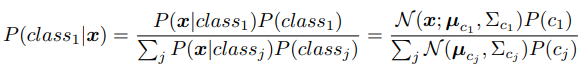

In [5]:
#========================================================================================== FULL BAYES

def cifar10_classifier_bayes(tst,mu,cov,p):
    Total_Dr=0.0
    all_NR=[]
    for i in range(0,10):
        
        Dr_Data = multivariate_normal.pdf(tst, mu[i], cov[i])     # Calculate probability density
        Data = (Dr_Data)*p[i]                                     #Multiply with priors
        
        Total_Dr = Total_Dr+Data                                  #Sum Data for all classes
        all_NR.append(Data)                                       #Collect Numerator data

    all_NR=np.asarray(all_NR)                                     #Convert to array
    out = np.divide(all_NR, Total_Dr)                             # Divide Nr and Dr
    Estimated_Img_class=out.argmax(axis=0)                        #Estimate the class.
    
    #print("Data: ",Data)
    #print("Total_Dr: ",Total_Dr)
    #print("all_NR: ",all_NR)
    #print("Outs: ",out)
    #print("Estimated_Img_class: ",Estimated_Img_class)
    
    return Estimated_Img_class

def batch_bayes(TST,Mew,cov,pri2): #tst sample scaled img array containing test imgs.#MU, SIG, Prior calculated earlier
    bayes_labels=np.array([])
    for i in range(TST.shape[0]):
        OP=cifar10_classifier_bayes(TST[i],Mew,cov,pri2)
        bayes_labels = np.append(bayes_labels,OP)
        #print(i) #Images processed
    #print("Full Bayes Predicted Label's Shape is: ",bayes_labels.shape) #verify the shape of predicted labels
    return bayes_labels  


**Run and Get Accuracy**

In [7]:
#============================================================================ Resizing Images
Accuracy_List=[]

RESIZE_1X1_DATA=cifar10_color(X_Pic)
RESIZE_1X1_TST=cifar10_color(Q_TST_Pic)
print("Resized Training Image's Dimensions:" ,RESIZE_1X1_DATA.shape)  
print("Resized Test Image's Dimensions:" ,RESIZE_1X1_TST.shape)  
print()


#========= Training FULL bayes AT 1X1 to fetch Mu,Covariance etc..

print("#========= Training FULL Bayes")
MU2,COV,PRIOR2=cifar_10_bayes_learn(RESIZE_1X1_DATA,Y)
print("Full Bayes MU's Shape",MU2.shape)
print("Full Bayes Covariance's Shape",COV.shape)
print("Full Bayes Prior's Shape",PRIOR2.shape)
print()

#========= RUNNING FULL BAYES at 1X1 AND FETCHING ACCURACY

print("#========= RUNNING FULL BAYES at 1X1 AND FETCHING ACCURACY")
BATCH_bayes_full=batch_bayes(RESIZE_1X1_TST,MU2,COV,PRIOR2).astype('int')
BATCH_bayes_full_Acc=class_acc(BATCH_bayes_full,Q_Label)      #Calculate accuracy % of this TEST data set by Comparing Predicted Labels to Ground truth labels 
print("Full Bayes Accuracy in %: ",BATCH_bayes_full_Acc)
print()



Resized Training Image's Dimensions: (50000, 3)
Resized Test Image's Dimensions: (10000, 3)

#========= Training FULL Bayes
Sorting Resized Images according to their Labels
Full Bayes MU's Shape (10, 3)
Full Bayes Covariance's Shape (10, 3, 3)
Full Bayes Prior's Shape (10,)

#========= RUNNING FULL BAYES at 1X1 AND FETCHING ACCURACY
Full Bayes Accuracy in %:  24.7

